In [1]:
import pandas as pd
import numpy as np
import os
import gzip
import jsonlines
import importlib
import sys
import nltk
import json
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])
stopwords = set(stopwords.words("english"))

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /home/peichi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/peichi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
FIG_PATH = "results/"

## Indexing

In [3]:
# importlib.reload(sys.modules['indexing'])
from indexing import Indexer, IndexType, BasicInvertedIndex
from document_preprocessor import RegexTokenizer

/home/peichi/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
dataset_file_path = "data/postings_dataset.jsonl"

In [5]:
print('initializing tokenizer...')
preprocessor = RegexTokenizer('\w+')

print('reading stopwords...')
stopwords = stopwords
# with open('data/stopwords.txt', 'r') as file:
#     for stopword in file:
#         stopwords.add(stopword[:-1])

print('indexing document...')
title_index_directory_name = 'data/index-title'
if os.path.exists(title_index_directory_name):
    print('- reading title index from file...')
    title_index = BasicInvertedIndex()
    title_index.load(title_index_directory_name)
else:
    print('- creating title index...')
    title_index = Indexer.create_index(
        IndexType.BasicInvertedIndex, dataset_file_path, preprocessor, stopwords, 0, text_key='title')
print("number of documents", title_index.statistics['number_of_documents'])
main_index_directory_name = 'data/index-description_mwf10'
if os.path.exists(main_index_directory_name):
    print('- reading document index from file...')
    main_index = BasicInvertedIndex()
    main_index.load(main_index_directory_name)
else:
    print('- creating document index...')
    main_index = Indexer.create_index(
        IndexType.BasicInvertedIndex, dataset_file_path, preprocessor, stopwords, 10, text_key="description")
print("number of documents", main_index.statistics['number_of_documents'])

initializing tokenizer...
reading stopwords...
indexing document...
- reading title index from file...
number of documents 123842
- reading document index from file...
number of documents 123842


# Ranking

In [6]:
# importlib.reload(sys.modules['relevance'])
from relevance import run_relevance_tests
postings_filename = "data/predicted_postings.csv.gz"
job_category_filename = "data/job_categories.json"
resume_data_filename = "data/resume_data.csv"
training_filename = "data/train_rel_temp.csv"
testing_filename = "data/test_rel_temp.csv"
embeddings_filename = "data/description_embeddings.all-MiniLM-L6-v2.npy"

In [7]:
testing_resume_data = pd.read_csv(resume_data_filename)
testing_cat_cnt = testing_resume_data["Category"].value_counts()
testing_cat_cnt

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

In [8]:
len(testing_cat_cnt)

24

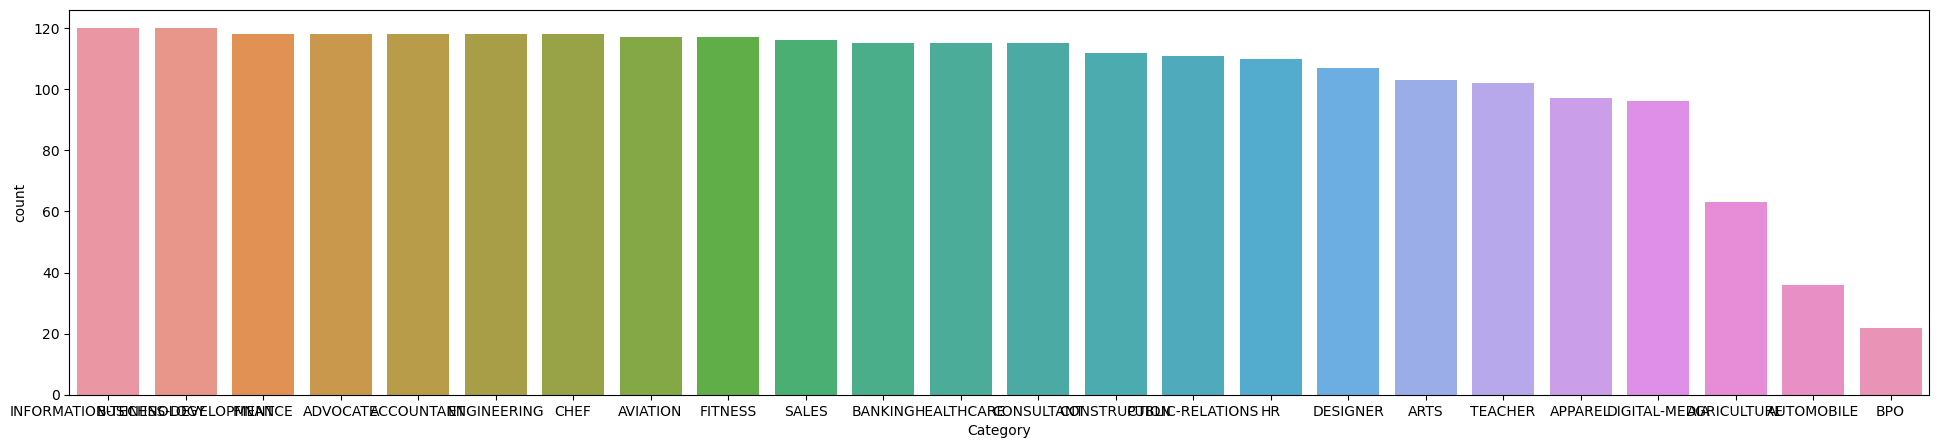

In [9]:
plt.figure(figsize=(24,5))
testing_cat_cnt = pd.DataFrame(testing_cat_cnt).reset_index().rename(columns={"index": "value", 0: "count"})
sns.barplot(x='Category', y='count', data=testing_cat_cnt)
plt.savefig(FIG_PATH + "testing_categories.png")

In [10]:
postings_data = pd.read_csv(postings_filename)

In [11]:
postings_cat = postings_data["predicted"].value_counts(dropna=False)

In [12]:
postings_cat

predicted
INFORMATION-TECHNOLOGY    23451
HEALTHCARE                21867
SALES                     16224
BUSINESS-DEVELOPMENT      14769
HR                        11424
ENGINEERING                8763
ACCOUNTANT                 4223
FINANCE                    3667
ADVOCATE                   2421
CONSULTANT                 2388
TEACHER                    2279
CHEF                       1829
DESIGNER                   1824
CONSTRUCTION               1677
BANKING                    1669
AUTOMOBILE                 1627
FITNESS                    1206
BPO                         915
AVIATION                    879
PUBLIC-RELATIONS            740
Name: count, dtype: int64

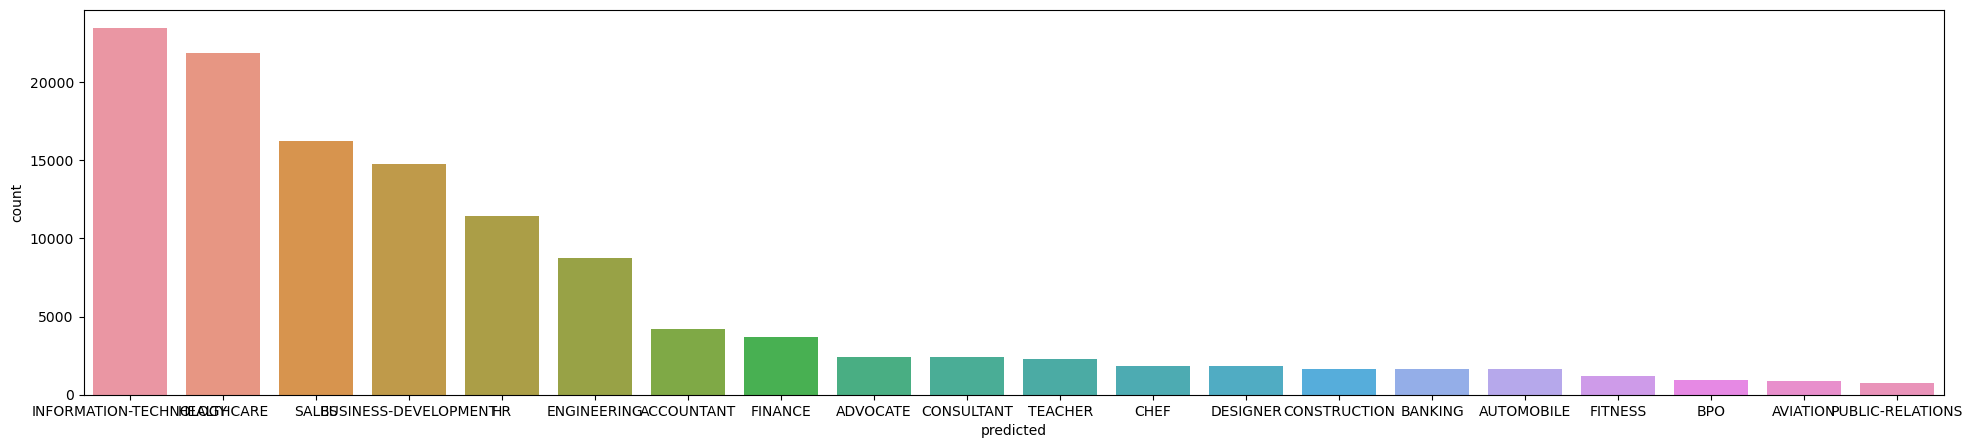

In [13]:
plt.figure(figsize=(24,5))
postings_cat = pd.DataFrame(postings_cat).reset_index().rename(columns={"index": "value", 0: "count"})
sns.barplot(x='predicted', y='count', data=postings_cat)
plt.savefig(FIG_PATH + "postings_categories.png")

## BM25 Ranking

In [14]:
from ranker import BM25, Ranker

scorer = BM25(main_index)
ranker = Ranker(main_index, preprocessor, stopwords, scorer)

In [15]:
bm25_score = run_relevance_tests(resume_data_filename, testing_filename, ranker)
bm25_score

100%|██████████| 10/10 [03:59<00:00, 23.99s/it]


{'map': 0.0,
 'ndcg': 0.0,
 'map_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'ndcg_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'time': [24.50352382659912,
  30.11856245994568,
  25.963388919830322,
  29.157628774642944,
  23.25001549720764,
  9.72841191291809,
  20.378913640975952,
  26.2238872051239,
  25.394898176193237,
  25.170969247817993]}

## Major Class Ranking

In [16]:
# importlib.reload(sys.modules['class_ranker'])
from class_ranker import MajorClassRanker

mc_ranker = MajorClassRanker(postings_filename)

In [17]:
mc_score = run_relevance_tests(resume_data_filename, testing_filename, mc_ranker)
mc_score

100%|██████████| 10/10 [00:00<00:00, 162.71it/s]


{'map': 0.0,
 'ndcg': 0.0,
 'map_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'ndcg_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'time': [0.008717775344848633,
  0.0066149234771728516,
  0.006223917007446289,
  0.005886077880859375,
  0.005910158157348633,
  0.005730628967285156,
  0.0056154727935791016,
  0.0055348873138427734,
  0.0055882930755615234,
  0.005499839782714844]}

In [18]:
mc_ranker.major_cat

'INFORMATION-TECHNOLOGY'

## Random Class Ranking

In [19]:
# importlib.reload(sys.modules['class_ranker'])
from class_ranker import RandomClassRanker

rc_ranker = RandomClassRanker(postings_filename)

In [20]:
rc_score = run_relevance_tests(resume_data_filename, testing_filename, rc_ranker)
rc_score

100%|██████████| 10/10 [00:00<00:00, 612.63it/s]


{'map': 0.0,
 'ndcg': 0.0,
 'map_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'ndcg_list': [0, 0, 0, 0.0, 0.0, 0.0, 0, 0.0, 0, 0],
 'time': [0.001832723617553711,
  0.001013040542602539,
  0.0007722377777099609,
  0.0011191368103027344,
  0.006008625030517578,
  0.0016641616821289062,
  0.0009055137634277344,
  0.001148223876953125,
  0.0009009838104248047,
  0.0008518695831298828]}

In [21]:
used_cat = Counter(rc_ranker.used_cat)
used_cat

Counter({'CONSULTANT': 1,
         'CHEF': 1,
         'FITNESS': 1,
         'TEACHER': 1,
         'INFORMATION-TECHNOLOGY': 1,
         'FINANCE': 1,
         'BANKING': 1,
         'ADVOCATE': 1,
         'CONSTRUCTION': 1,
         'AUTOMOBILE': 1})

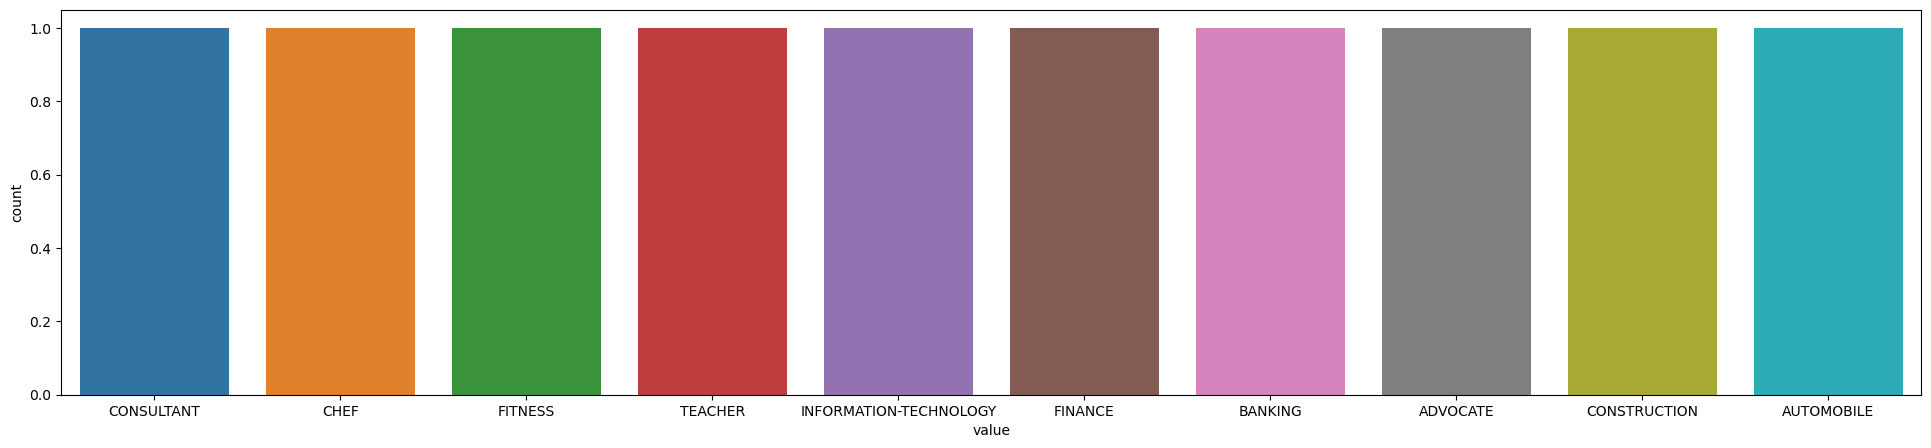

In [22]:
plt.figure(figsize=(24,5))
used_cat = pd.DataFrame.from_dict(used_cat, orient="index").reset_index().rename(columns={"index": "value", 0: "count"})
sns.barplot(x="value", y="count", data=used_cat)
plt.savefig(FIG_PATH + "random_cat.png")

## LLM Ranking

In [23]:
# importlib.reload(sys.modules['class_ranker'])
from class_ranker import LLMRanker

model_name = './posting_classifier/models/job_classification_11091504'
llm_ranker = LLMRanker(model_name, postings_filename)

In [24]:
llm_score = run_relevance_tests(resume_data_filename, testing_filename, llm_ranker)
llm_score

100%|██████████| 10/10 [00:00<00:00, 26.37it/s]


{'map': 0.0016666666666666666,
 'ndcg': 0.01934264036172708,
 'map_list': [0.0,
  0.0,
  0.016666666666666666,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'ndcg_list': [0, 0.0, 0.1934264036172708, 0.0, 0.0, 0.0, 0, 0, 0.0, 0.0],
 'time': [0.043126583099365234,
  0.04031848907470703,
  0.03545427322387695,
  0.03783130645751953,
  0.03456401824951172,
  0.04135417938232422,
  0.035927772521972656,
  0.038346052169799805,
  0.03534650802612305,
  0.03448843955993652]}

## L2R with BM25 Ranking

In [25]:
# importlib.reload(sys.modules['l2r'])
from l2r import L2RFeatureExtractor, L2RRanker
from vector_ranker import VectorRanker

print("creating feature extractor...")
fe = L2RFeatureExtractor(main_index,
                            title_index,
                            # doc_category_info,
                            preprocessor,
                            stopwords,
                            # recognized_categories,
                            # network_features
                        )

print("creating l2r ranker...")
l2r_bm25 = L2RRanker(main_index, title_index, preprocessor,
                    stopwords, ranker, fe)

creating feature extractor...
creating l2r ranker...


In [26]:
# l2r_bm25.output_data(training_filename, resume_data_filename)

In [27]:
print('training...')
l2r_bm25.train(training_filename, resume_data_filename)

training...


100%|██████████| 10/10 [00:47<00:00,  4.75s/it]

[LightGBM] [Info] Total Bins 1307
[LightGBM] [Info] Number of data points in the train set: 715, number of used features: 9


In [28]:
l2r_bm25_score = run_relevance_tests(resume_data_filename, testing_filename, l2r_bm25)
l2r_bm25_score

100%|██████████| 10/10 [04:41<00:00, 28.16s/it]


{'map': 0.0,
 'ndcg': 0.0,
 'map_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'ndcg_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'time': [28.476768970489502,
  36.10291624069214,
  30.85412049293518,
  33.8216450214386,
  27.131881713867188,
  11.39504861831665,
  23.58005666732788,
  31.09902787208557,
  30.468640565872192,
  28.66816020011902]}

plot feature importance...
- number of used features 9
['doc_len', 'title_len', 'query_len', 'doc_tf', 'doc_tf_idf', 'title_tf', 'title_tf_idf', 'bm25', 'pivoted norm']
plot feature importance...
binary features importance...
Empty DataFrame
Columns: [feature, importance]
Index: []


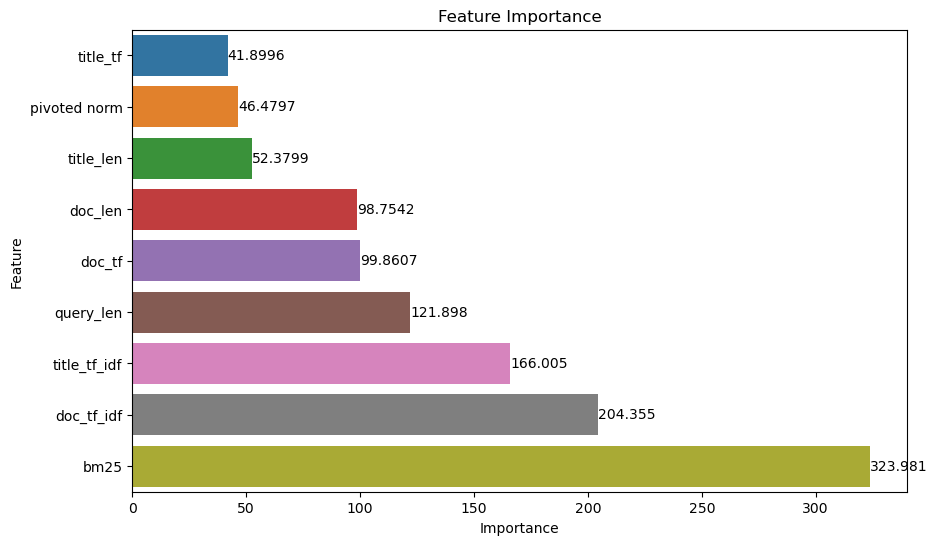

In [29]:
print('plot feature importance...')
feature_names = [
        'doc_len', 'title_len', 'query_len',
        'doc_tf', 'doc_tf_idf', 'title_tf', 'title_tf_idf',
        'bm25', 'pivoted norm', #'pagerank', 'HITS hub', 'HITS auth',
        # 'skill similarity'
        # 'cross encoder',
        #'title_myscore', 'doc_myscore', 'total_cat'
]
num_binary = len(feature_names)
num_cat = len(l2r_bm25.model.ranker.feature_name_) - len(feature_names)
for i in range(num_cat):
    feature_names.append(f'cat{i}')
print("- number of used features", len(l2r_bm25.model.ranker.feature_name_))
print(feature_names)
importance = l2r_bm25.model.ranker.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})
df_binary = importance_df.iloc[num_binary:]
df = importance_df.iloc[:num_binary]
df = df.sort_values(by=['importance'])

# Plot feature importance
print('plot feature importance...')
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='importance', y='feature')
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig(FIG_PATH + 'feature_importance_aug.png')

print('binary features importance...')
df_binary = importance_df.iloc[num_binary:]
df_binary = df_binary.sort_values(by=['importance'], ascending=False)
print(df_binary.head(5))

## L2R with VectorRanker Ranking

In [30]:
document_dict = {}
if dataset_file_path.endswith('.gz'):
    with gzip.open(dataset_file_path, 'rt', encoding='utf-8') as f:
        for line in tqdm(f):
            print(line)
            doc = json.loads(line)
            document_dict[doc['job_id']] = doc['description']
else:
    with jsonlines.open(dataset_file_path) as f:
        for doc in tqdm(f):
            document_dict[doc['job_id']] = doc['description']

123842it [00:02, 52980.61it/s]


In [31]:
docids = []
docids_file_path = 'data/job_posting_ids.txt'
with open(docids_file_path, 'r') as f:
    for line in tqdm(f):
        docids.append(int(line))

123842it [00:00, 2636344.24it/s]


In [32]:
# importlib.reload(sys.modules['vector_ranker'])
from ranker import *
from vector_ranker import VectorRanker
from l2r import L2RFeatureExtractor, L2RRanker

print("creating skills scorer...")
skills_embeddings_fill_path = 'data/skills_embeddings.npy'
skills_embeddings = np.load(skills_embeddings_fill_path)
skill_scorer = SkillSimilarityScorer(skills_embeddings, docids, skill_pattern_path="preprocessing/jz_skill_patterns.jsonl")

print("creating cross encoder scorer...")
cemodel = CrossEncoderScorer(document_dict)


print("creating feature extractor...")
fe = L2RFeatureExtractor(main_index,
                            title_index,
                            # doc_category_info,
                            preprocessor,
                            stopwords,
                            # recognized_categories,
                            # network_features,
                            cemodel,
                            skill_scorer
                        )

print("creating vector ranker...")
embeddings = np.load(embeddings_filename)
embeddings = np.squeeze(embeddings, axis=1) 

model_name = 'sentence-transformers/msmarco-MiniLM-L12-cos-v5'
ranker = VectorRanker(model_name, embeddings, docids)

print("creating l2r ranker...")
l2r_vr = L2RRanker(main_index, title_index, preprocessor,
                    stopwords, ranker, fe)

creating skills scorer...
creating cross encoder scorer...
creating feature extractor...
creating vector ranker...
creating l2r ranker...


In [33]:
print('training...')
l2r_vr.train(training_filename, resume_data_filename)

training...


100%|██████████| 10/10 [02:39<00:00, 15.94s/it]

[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 715, number of used features: 11


In [34]:
l2r_vr_score = run_relevance_tests(resume_data_filename, testing_filename, l2r_vr)
l2r_vr_score

100%|██████████| 10/10 [03:17<00:00, 19.77s/it]


{'map': 0.0,
 'ndcg': 0.0,
 'map_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'ndcg_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'time': [18.677096366882324,
  27.49028491973877,
  19.746755838394165,
  21.58306622505188,
  18.909637451171875,
  11.339717626571655,
  17.009643077850342,
  23.28515934944153,
  20.297864198684692,
  19.302905321121216]}

plot feature importance...
- number of used features 11
['doc_len', 'title_len', 'query_len', 'doc_tf', 'doc_tf_idf', 'title_tf', 'title_tf_idf', 'bm25', 'pivoted norm', 'skill similarity', 'cross encoder']
plot feature importance...
binary features importance...
Empty DataFrame
Columns: [feature, importance]
Index: []


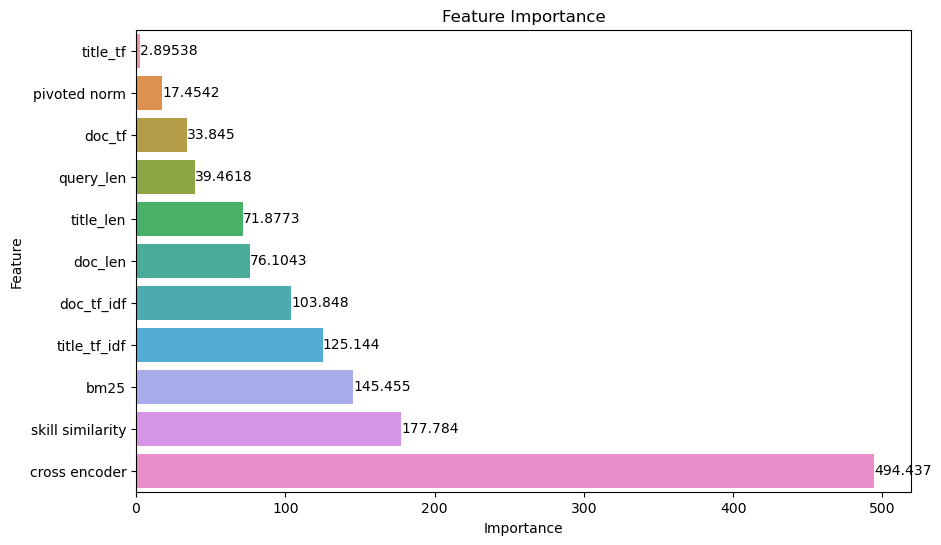

In [35]:
print('plot feature importance...')
feature_names = [
        'doc_len', 'title_len', 'query_len',
        'doc_tf', 'doc_tf_idf', 'title_tf', 'title_tf_idf',
        'bm25', 'pivoted norm', #'pagerank', 'HITS hub', 'HITS auth',
        'skill similarity',
        'cross encoder',
        #'title_myscore', 'doc_myscore', 'total_cat'
]
num_binary = len(feature_names)
num_cat = len(l2r_vr.model.ranker.feature_name_) - len(feature_names)
for i in range(num_cat):
    feature_names.append(f'cat{i}')
print("- number of used features", len(l2r_vr.model.ranker.feature_name_))
print(feature_names)
importance = l2r_vr.model.ranker.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})
df_binary = importance_df.iloc[num_binary:]
df = importance_df.iloc[:num_binary]
df = df.sort_values(by=['importance'])

# Plot feature importance
print('plot feature importance...')
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='importance', y='feature')
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig(FIG_PATH + 'feature_importance_aug.png')

print('binary features importance...')
df_binary = importance_df.iloc[num_binary:]
df_binary = df_binary.sort_values(by=['importance'], ascending=False)
print(df_binary.head(5))

## L2R with Document Augmentation Ranking

## Pseudofeedback

## Plot

number of queries 10


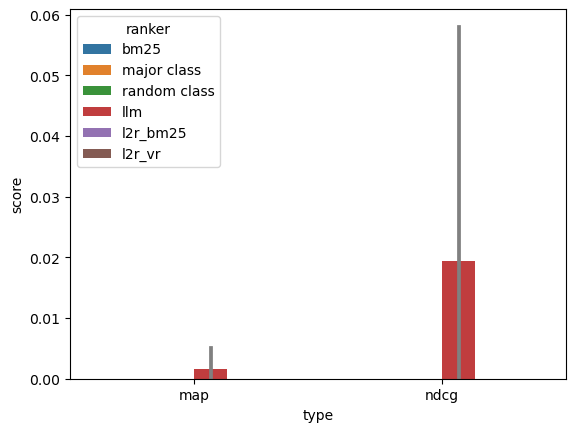

In [36]:
df = []
l = len(llm_score['map_list'])
print("number of queries", l)
for i in range(l):
    df.append({'ranker': 'bm25', 'type': 'map', 'score': bm25_score['map_list'][i]})
    df.append({'ranker': 'bm25', 'type': 'ndcg', 'score': bm25_score['ndcg_list'][i]})
    df.append({'ranker': 'major class', 'type': 'map', 'score': mc_score['map_list'][i]})
    df.append({'ranker': 'major class', 'type': 'ndcg', 'score': mc_score['ndcg_list'][i]})
    df.append({'ranker': 'random class', 'type': 'map', 'score': rc_score['map_list'][i]})
    df.append({'ranker': 'random class', 'type': 'ndcg', 'score': rc_score['ndcg_list'][i]})
    df.append({'ranker': 'llm', 'type': 'map', 'score': llm_score['map_list'][i]})
    df.append({'ranker': 'llm', 'type': 'ndcg', 'score': llm_score['ndcg_list'][i]})
    df.append({'ranker': 'l2r_bm25', 'type': 'map', 'score': l2r_bm25_score['map_list'][i]})
    df.append({'ranker': 'l2r_bm25', 'type': 'ndcg', 'score': l2r_bm25_score['ndcg_list'][i]})
    df.append({'ranker': 'l2r_vr', 'type': 'map', 'score': l2r_vr_score['map_list'][i]})
    df.append({'ranker': 'l2r_vr', 'type': 'ndcg', 'score': l2r_vr_score['ndcg_list'][i]})
    # df1.append({'ranker': 'l2r_aug', 'type': 'map', 'score': l2r_aug_score['map_list'][i]})
    # df1.append({'ranker': 'l2r_aug', 'type': 'ndcg', 'score': l2r_aug_score['ndcg_list'][i]})

df = pd.DataFrame(df)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x='type', y='score', hue='ranker', data=df, errcolor='grey')
# bm25_avg = [bm25_score['map'], bm25_score['ndcg']]
# rc_avg = [rc_score['map'], rc_score['ndcg']]
# mc_avg = [mc_score['map'], mc_score['ndcg']]
# llm_avg = [llm_score['map'], llm_score['ndcg']]
# # l2r_basic_avg = [l2r_basic_score['map'], l2r_basic_score['ndcg']]
# # l2r_avg = [l2r_score['map'], l2r_score['ndcg']]
# # l2r_aug_avg = [l2r_aug_score['map'], l2r_aug_score['ndcg']]
# for i, (v1,v2,v3,v4) in enumerate(zip(bm25_avg, rc_avg, mc_avg, llm_avg)):
#     ax1.text(i-0.3, v1+0.01, "{:.3f}".format(v1), ha='center', color='black')
#     ax1.text(i-0.1, v2+0.01, "{:.3f}".format(v2), ha='center', color='black')
#     ax1.text(i+0.1, v3+0.01, "{:.3f}".format(v3), ha='center', color='black')
#     ax1.text(i+0.3, v4+0.01, "{:.3f}".format(v4), ha='center', color='black')
#     ax1.plot(i-0.3, v1, "_", markersize=10, color="black")
#     ax1.plot(i-0.1, v2, "_", markersize=10, color="black")
#     ax1.plot(i+0.1, v3, "_", markersize=10, color="black")
#     ax1.plot(i+0.3, v4, "_", markersize=10, color="black")

plt.savefig(FIG_PATH + 'ranker_scores.png')

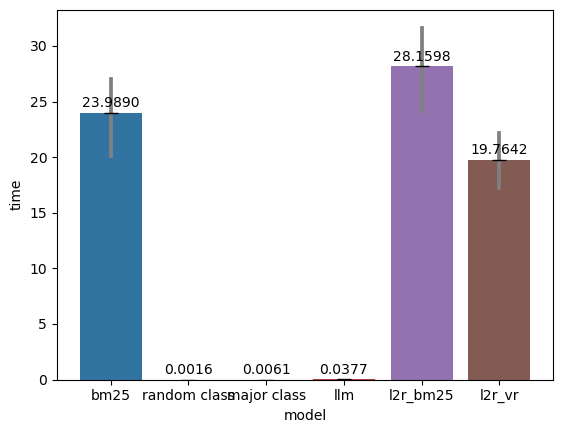

In [37]:
import numpy as np
df = []
for i in range(len(rc_score["time"])):
    df.append({'model': 'bm25', 'time': bm25_score['time'][i]})
    df.append({'model': 'random class', 'time': rc_score['time'][i]})
    df.append({'model': 'major class', 'time': mc_score['time'][i]})
    df.append({'model': 'llm', 'time': llm_score['time'][i]})
    df.append({'model': 'l2r_bm25', 'time': l2r_bm25_score['time'][i]})
    df.append({'model': 'l2r_vr', 'time': l2r_vr_score['time'][i]})
    
df = pd.DataFrame(df)
ax = sns.barplot(x='model', y='time', data=df, errcolor="grey")
time_avg = [np.mean(bm25_score['time']), np.mean(rc_score['time']), np.mean(mc_score['time']), np.mean(llm_score['time']), np.mean(l2r_bm25_score['time']), np.mean(l2r_vr_score['time'])]
for i, v in enumerate(time_avg):
    ax.text(i, v+0.5, "{:.4f}".format(v), ha='center', color='black')
    ax.plot(i, v, "_", markersize=10, color="black")
plt.savefig(FIG_PATH + 'ranking_time.png')